In [1]:
library(tidyverse)
library(stringr)
library(magrittr)

source("../R/utils.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract



### Load the averages of conservation tracks in different windows

In [45]:
files <- list.files("../clean_data/annotations", pattern="*.bed$", full.names=TRUE)

In [46]:
window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

In [4]:
window_avgs_wide <- spread(window_avgs_long, track, value)

### Load a subset of annotation tracks used by CADD

In [5]:
suppressMessages(
    cadd_wide <-
        load_annotations("../clean_data/annotations.tsv") %>%
        select(chrom, pos, bStatistic, priPhCons, priPhyloP, Consequence, AnnoType) %>% 
        rename(bval=bStatistic)
)

Warning message:
"673 parsing failures.
 row            col               expected  actual
2136 mapAbility35bp no trailing characters .5     
4607 mapAbility35bp no trailing characters .333333
5028 mapAbility35bp no trailing characters .5     
5379 mapAbility35bp no trailing characters .5     
5819 mapAbility35bp no trailing characters .5     
.... .............. ...................... .......
See problems(...) for more details.
"

In [6]:
cadd_long <- gather(cadd_wide, track, value, -c(chrom, pos, Consequence, AnnoType))

### Merge both tables

In [7]:
all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)
all_annots_long <- bind_rows(window_avgs_long, cadd_long)

Joining, by = c("chrom", "pos")


In [8]:
# read processed SNP tables of aDNA samples and SGDP individuals,
# merge them and intersect them with the annotations data
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                       "../clean_data/sgdp.tsv",
                       "../clean_data/archaics.tsv",
                       filter_damage=TRUE, # remove potential aDNA substitutions (C->T, G->A)
                       metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
    inner_join(all_annots_wide)

# process the SGDP metainformation table
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(!(pop == "Oceania" & Country != "PapuaNewGuinea")) %>%
  mutate(pop=ifelse(pop == "Oceania", "Papuan", pop))

emh_info <-
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH") %>%
  filter(name %in% colnames(all_snps),
         ! name %in% c("Continenza", "Kostenki12", "Ostuni2",
                       "Pavlov1", "Vestonice15", "Vestonice43",
                       "Vestonice13", "Oase1", "Muierii2",
                       "AfontovaGora2"))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age,
         name=factor(name, levels=name),
         pop=as.factor(pop))

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message:
"Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]"Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message in one_of(sgdp_info$name):
"Unknown variables: `S_Australian_1`, `S_Australian_5`"Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),

In [9]:
head(all_snps)

chrom,pos,ref,alt,AfontovaGora2,AfontovaGora3,Continenza,Vestonice13,Vestonice15,Vestonice16,⋯,priPhCons__50000bp,priPhyloP__100000bp,priPhyloP__10000bp,priPhyloP__25000bp,priPhyloP__50000bp,bval,priPhCons,priPhyloP,Consequence,AnnoType
1,847983,C,T,NA,NA,NA,NA,NA,NA,,0.044204,-0.019379,-0.024890,-0.027014,-0.021022,958,0.187,0.557,NONCODING_CHANGE,NonCodingTranscript
1,853089,G,C,NA,NA,NA,NA,NA,NA,,0.042506,-0.018796,-0.059151,-0.023319,-0.012932,958,0.013,0.486,NONCODING_CHANGE,NonCodingTranscript
1,853596,A,G,NA,0,NA,NA,NA,NA,,0.041267,-0.018899,-0.052031,-0.023065,-0.012214,958,0.001,0.557,NONCODING_CHANGE,NonCodingTranscript
1,854793,A,C,NA,NA,NA,NA,NA,NA,,0.041644,-0.019988,-0.043938,-0.026716,-0.010871,958,0.000,-0.908,NONCODING_CHANGE,NonCodingTranscript
1,867552,T,G,NA,NA,NA,NA,NA,NA,,0.036932,-0.021147,-0.013007,0.008596,-0.018548,946,0.997,0.515,UPSTREAM,Intergenic
1,871401,A,G,NA,NA,NA,NA,NA,NA,,0.036945,-0.023430,0.010197,0.008644,-0.020321,946,0.013,0.064,REGULATORY,RegulatoryFeature


### Mean conservation values in windows

In [18]:
filter(all_annots_long, str_detect(track, "density") | str_detect(track, "bval")) %>%
    group_by(track) %>%
    summarise(mean(value, na.rm=TRUE))

track,"mean(value, na.rm = TRUE)"
bval,802.88650201
bval__100000bp,803.35754465
bval__10000bp,802.98593776
bval__25000bp,803.09568356
bval__50000bp,803.22090464
exon_density__100000bp,0.02416733
exon_density__10000bp,0.02602537
exon_density__25000bp,0.02518902
exon_density__50000bp,0.02460969


### Plot distributions of average conservation values in windows of different sizes

In [10]:
plot_window_dist <- function(tr, df, lim=NULL) {
    p <- filter(df, str_detect(track, tr)) %>% 
        ggplot(aes(value, color=track, group=track)) +
            geom_density() +
            labs(title=tr)

    if (!is.null(lim)) {
        p + xlim(lim)
    } else{
        p
    }
}

In [12]:
options(repr.plot.width=10, repr.plot.height=3)

Warning message:
"Removed 719 rows containing non-finite values (stat_density)."

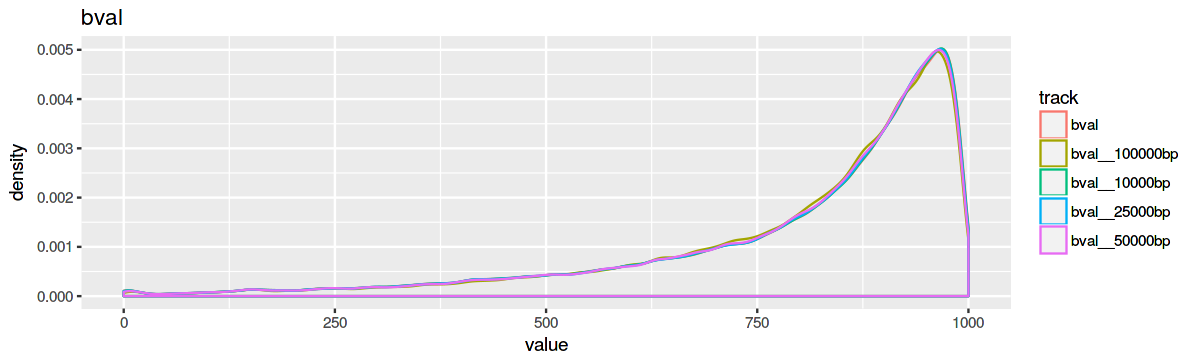

Warning message:
"Removed 612447 rows containing non-finite values (stat_density)."

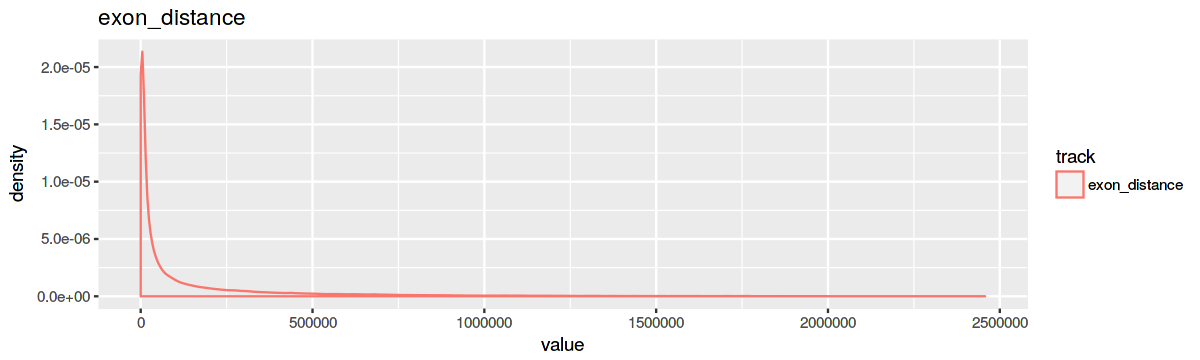

Warning message:
"Removed 10327 rows containing non-finite values (stat_density)."

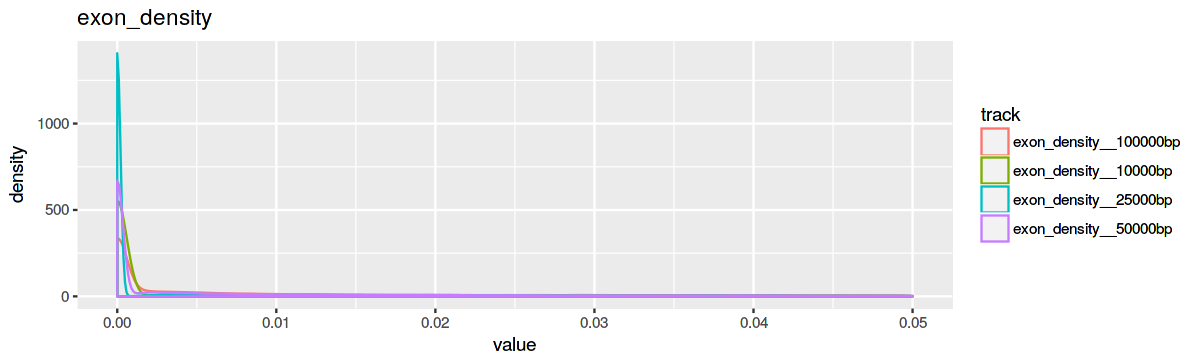

Warning message:
"Removed 113875 rows containing non-finite values (stat_density)."

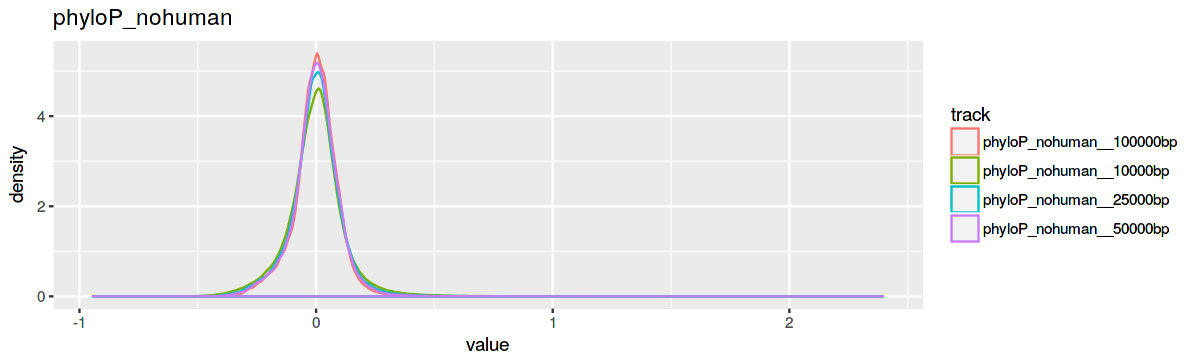

Warning message:
"Removed 975 rows containing non-finite values (stat_density)."

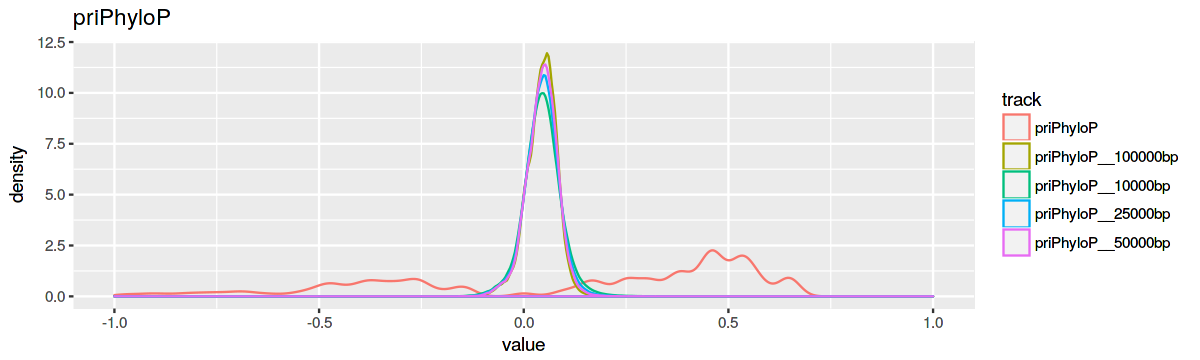

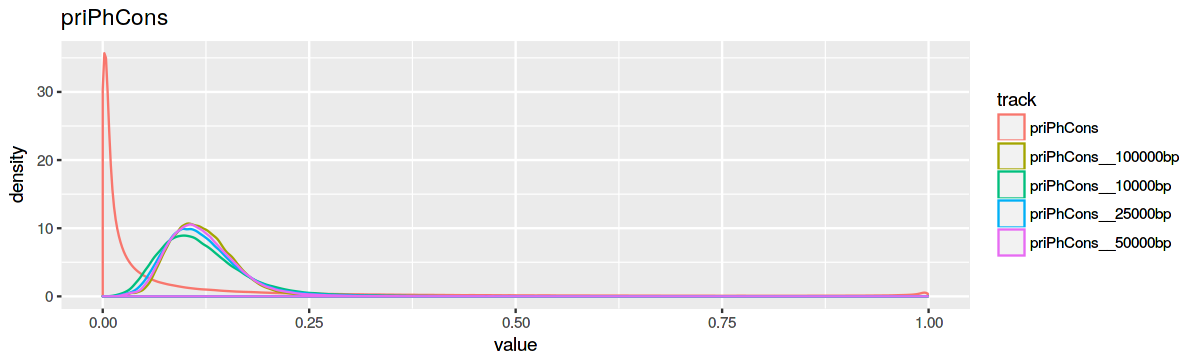

In [11]:
plot_window_dist("bval", all_annots_long)
plot_window_dist("exon_distance", all_annots_long)
plot_window_dist("exon_density", all_annots_long, c(0, 0.05))
plot_window_dist("phyloP_nohuman", all_annots_long)
plot_window_dist("priPhyloP", all_annots_long, c(-1, 1))
plot_window_dist("priPhCons", all_annots_long)

In [22]:
options(repr.plot.width=5, repr.plot.height=5)

In [23]:
x <- sample_n(all_snps, 1000)

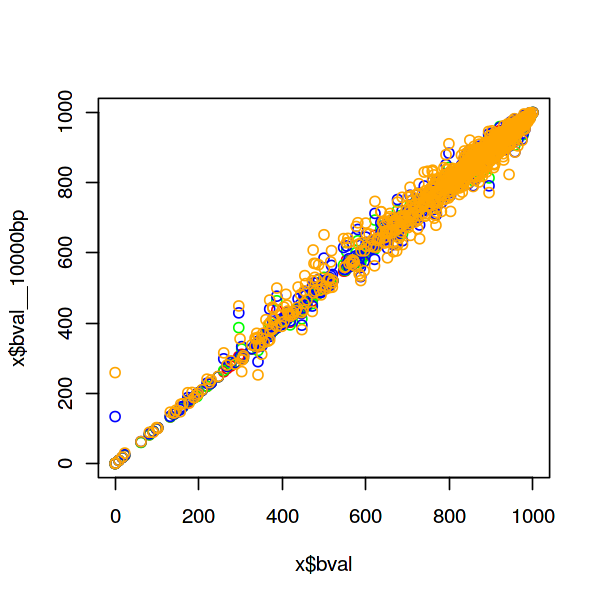

In [25]:
plot(x$bval, x$bval__10000bp, col="red")
points(x$bval, x$bval__25000bp, col="green")
points(x$bval, x$bval__50000bp, col="blue")
points(x$bval, x$bval__100000bp, col="orange")

In [16]:
a <- window_avgs_long %>% filter(track == "bval__100000bp") %>% select(chrom, pos, a=value)

In [17]:
head(a)

chrom,pos,a
1,847983,952.9395
1,853089,949.5297
1,853596,949.2357
1,854793,948.5645
1,858862,946.5280
1,867151,943.3367


In [18]:
b <- read.table("../raw_data//archaic.bed.sorted.bvals.w100kb") %>% setNames(c("chrom", "start", "pos", "count", "bval", "q5", "q95")) %>% select(chrom, pos, b=bval)

In [19]:
head(b)

chrom,pos,b
1,847983,959.1149
1,853089,958.3916
1,853596,958.3144
1,854793,958.1283
1,858862,957.4485
1,867151,955.7910


In [27]:
x <- inner_join(a, b)

Joining, by = c("chrom", "pos")


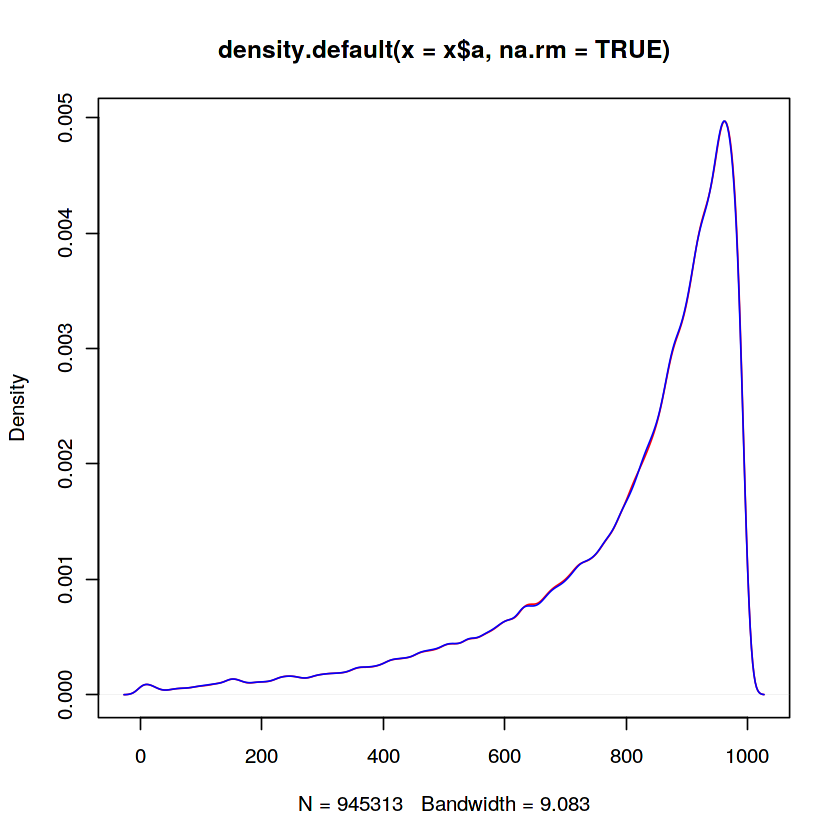

In [31]:
plot(density(x$a, na.rm=TRUE), col="red")
lines(density(x$b, na.rm=TRUE), col="blue")